# Binarization and Connected Component Analysis
This notebook explains some basic image processing concepts.  We will work only on grayscale images today, because we don't need the additional complication of colors.

## Preparation

In [17]:
import pathlib
import numpy as np
import skimage
import skimage.data
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# plots directly in the notebook
%matplotlib inline 

# make figures larger
plt.rcParams["figure.figsize"] = (10,10)

# if you have a high-dpi monitor
#%config InlineBackend.figure_format = 'retina' 

import ipywidgets as widgets


### Load and display a grayscale image

[[ 47 123 133 ...  14   3  12]
 [ 93 144 145 ...  12   7   7]
 [126 147 143 ...   2  13   3]
 ...
 [ 81  79  74 ...   6   4   7]
 [ 88  82  74 ...   5   7   8]
 [ 91  79  68 ...   4  10   7]]
(303, 384)
float64


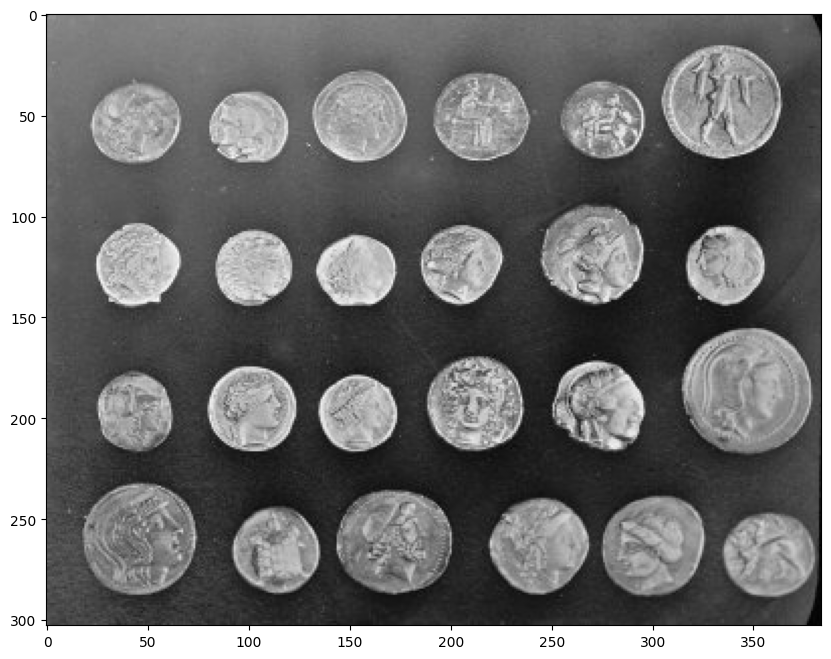

In [ ]:
im = skimage.data.coins()
print(im)
# im = skimage.color.rgb2gray(im)
im = skimage.img_as_float(im) # make sure our image is floating point in range [0,1]
# to read from a file: skimage.io.imread("myimage.png")
print(im.shape)
print(im.dtype)
plt.imshow(im,cmap="gray")

## Binarizing an image
We can obtain a binary image by _thresholding_ a grayscale image.  A binary image is often called a _mask_.

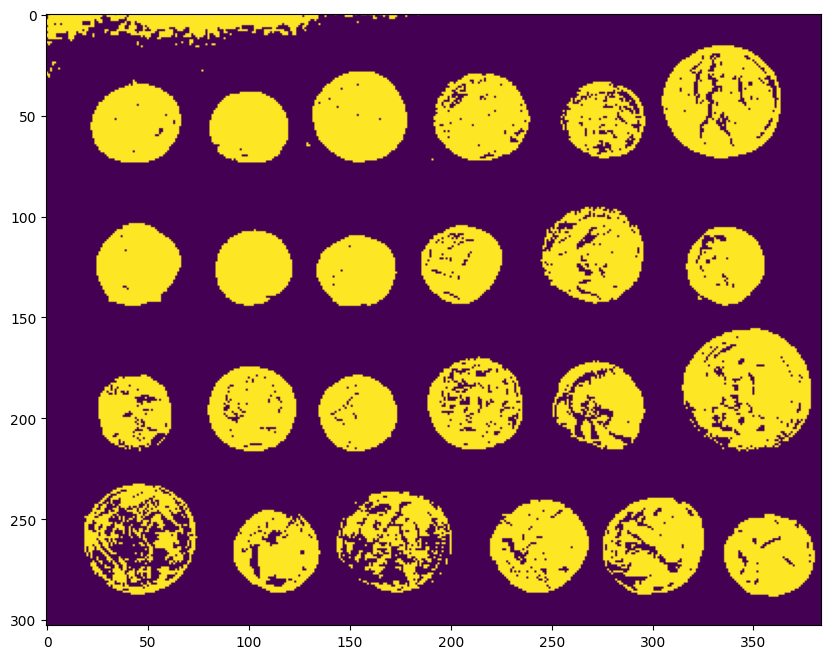

In [3]:
mask: np.ndarray = im > 0.50 # bright pixels will be True in the mask, others will be False 
plt.imshow(mask)

Of course, the result depends on the threshold. Find a good threshold to segment this specific image.

In [4]:
@widgets.interact(threshold = (0,1, 0.01))
def f(threshold):
    mask = im > threshold
    plt.imshow(mask)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

$0.50$ sounds like a good threshold for this image, but note that the approach does not segment every coin perfectly.

## Connected Component Analysis

Separating and analyzing the "islands" of `True` pixels in a binary image is called _connected component analysis_ ([documentation](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)).

In [5]:
import skimage.measure
labels = skimage.measure.label(im < 0.50)
print(f"Dimension of our image: {labels.shape}, Type: {labels.dtype}")
total_connected_regions: int = np.unique(labels).size
print(f"With 'skimage.measure.label(...)', we found {total_connected_regions} connected regions (inkl. background).")

Dimension of our image: (303, 384), Type: int32
With 'skimage.measure.label(...)', we found 477 connected regions (inkl. background).


`labels` contains one different number for each "island" of `True` in `mask`, and $0$ for pixels that are `False` in mask.  These islands are called _connected components_.

In [6]:
@widgets.interact(region = (0, total_connected_regions, 1))
def f(region):
    print(f"The connected component of region {region} contains {np.sum(labels == region)} pixels")
    plt.imshow(labels==region)
    plt.show()

interactive(children=(IntSlider(value=238, description='region', max=477), Output()), _dom_classes=('widget-in…

In [7]:
t = 0.50
labels = skimage.measure.label(im > t)

@widgets.interact(label = list(np.unique(labels)))
def f(label):
    print(f"The connected component with label {label} contains {np.sum(labels == label)} pixels")
    plt.imshow(labels == label)
    plt.show()

interactive(children=(Dropdown(description='label', options=(np.int32(0), np.int32(1), np.int32(2), np.int32(3…

The `regionprops` ([documentation](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)) function can compute properties for each connected component.  Some important properties are the following:

- `area : int` Number of pixels of the region.
- `bbox : tuple` Bounding box `(min_row, min_col, max_row, max_col)`. Pixels belonging to the bounding box are in the half-open interval `[min_row; max_row)` and `[min_col; max_col)`.
- `centroid : array` Centroid coordinate tuple `(row, col)`.
- `convex_area : int` Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
- `label : int` The label in the labeled input image.

Let's select only the large regions

In [8]:
labels = skimage.measure.label(im > 0.50)
regions: list = skimage.measure.regionprops(labels)
[region.area for region in regions if region.area > 100]

[np.float64(1140.0),
 np.float64(2288.0),
 np.float64(1645.0),
 np.float64(1491.0),
 np.float64(1365.0),
 np.float64(962.0),
 np.float64(1109.0),
 np.float64(1644.0),
 np.float64(1303.0),
 np.float64(1131.0),
 np.float64(1091.0),
 np.float64(1107.0),
 np.float64(1083.0),
 np.float64(2701.0),
 np.float64(1438.0),
 np.float64(1187.0),
 np.float64(1382.0),
 np.float64(943.0),
 np.float64(1117.0),
 np.float64(1202.0),
 np.float64(1147.0),
 np.float64(1583.0),
 np.float64(1577.0),
 np.float64(1160.0),
 np.float64(1354.0)]

In [9]:
regions: list = skimage.measure.regionprops(labels)
large_regions: list = [region for region in regions if region.area > 100]
print(f"There are {len(large_regions)} large regions")

There are 25 large regions


And let's now draw all bounding boxes for the large regions over the original image

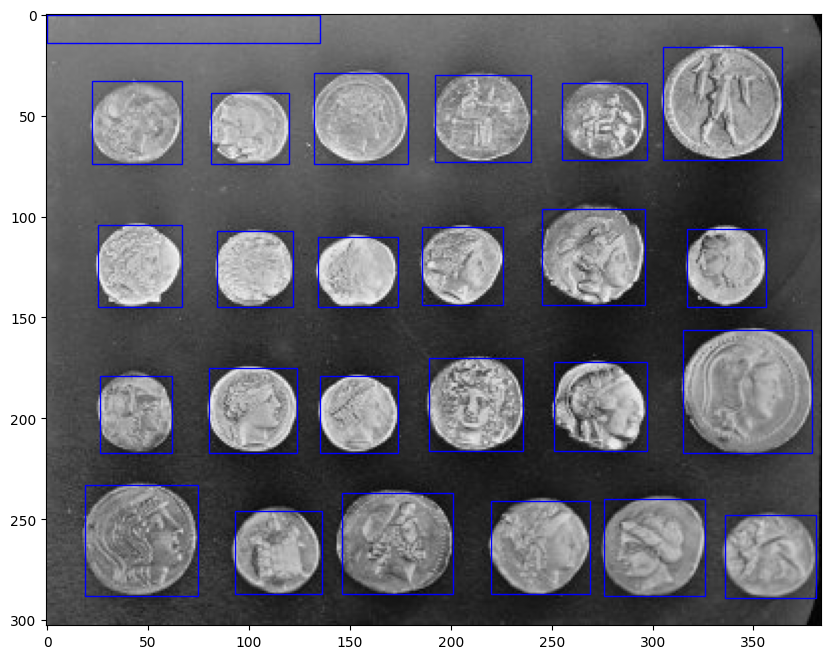

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im, cmap="gray")
for region in large_regions:
    (min_row, min_col, max_row, max_col) = region.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

The wide region at the top left can be filtered out if we say, that no side of one coin is larger than about 70px.

## Exercises
### Exercise 1
The approach above depends on the choice of two parameters: the threshold, and the minimum size of the connected component.  Refactor the code above in order to tweak both parameters interactively and check how the results are affected by them.   Can you find a setting for which you identify all and only the coin regions?

In [11]:
im_exercise = skimage.data.coins()
im_exercise = skimage.img_as_float(im_exercise)

def get_height_and_width_of_bbox(bbox: tuple) -> tuple[int, int]:
    (min_row, min_col, max_row, max_col) = bbox
    dimensions: tuple = (max_row - min_row, max_col - min_col)
    
    return dimensions

@widgets.interact(threshold = widgets.FloatSlider(value=0.50, min=0.0, max=1.0, step=0.01), 
                  min_size = widgets.IntSlider(value=250, min=10, max=500),
                  max_dimension = widgets.IntSlider(value=100, min=0, max=200, step=5),)
def f(threshold, min_size, max_dimension):
    labels = skimage.measure.label(im_exercise > threshold)
    all_regions: list = skimage.measure.regionprops(labels)
    large_regions: list = [region for region in all_regions if region.area > min_size]
    more_restricted_regions: list = [region for region in large_regions if max(get_height_and_width_of_bbox(region.bbox)) < max_dimension]

    fig, ax = plt.subplots()
    ax.imshow(im_exercise, cmap="gray")
    for region in more_restricted_regions:
        (min_row, min_col, max_row, max_col) = region.bbox
        width = max_col - min_col
        height = max_row - min_row
        rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), IntSlider(value=250…

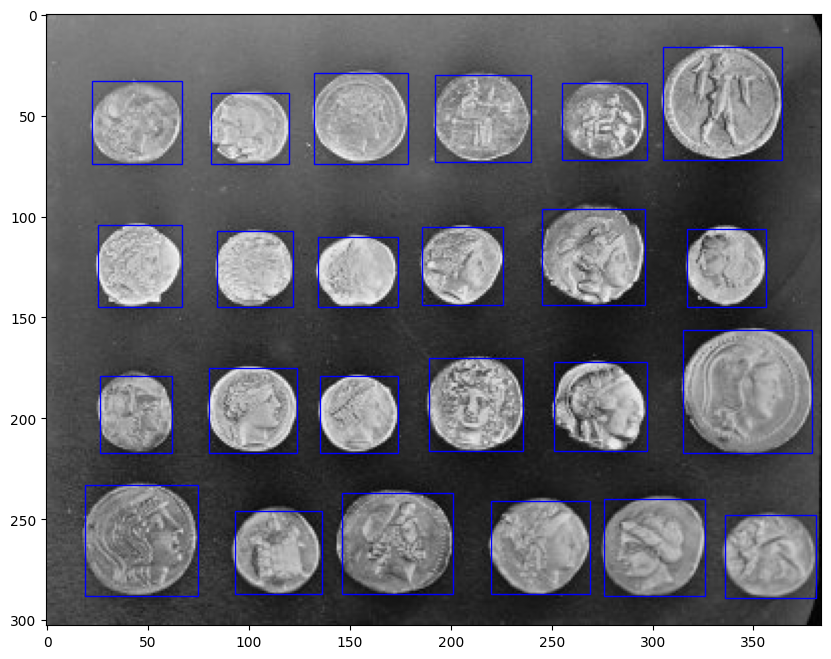

In [12]:
labels = skimage.measure.label(im_exercise > 0.5)
all_regions: list = skimage.measure.regionprops(labels)
large_regions: list = [region for region in all_regions if region.area > 250]
more_restricted_regions: list = [region for region in large_regions if max(get_height_and_width_of_bbox(region.bbox)) < 100]

_, ax = plt.subplots()
ax.imshow(im_exercise, cmap="gray")
for region in more_restricted_regions:
    (min_row, min_col, max_row, max_col) = region.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

### Exercise 2
Write a function that, given an image like the image above, crops each coin and saves it to a separate image file, named `00001.png`, `00002.png`, and so on. Use [`skimage.io.imsave(...)`](http://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imsave).

In [ ]:
# With values from above
labels = skimage.measure.label(im_exercise > 0.50)
all_regions: list = skimage.measure.regionprops(labels)
large_regions: list = [region for region in all_regions if region.area > 250]
more_restricted_regions: list = [region for region in large_regions if max(get_height_and_width_of_bbox(region.bbox)) < 100]
target_directory: pathlib.Path = pathlib.Path.cwd().joinpath('coins')
target_directory.mkdir(parents=True, exist_ok=True)

for idx, current_region in enumerate(more_restricted_regions):
    (min_row, min_col, max_row, max_col) = current_region.bbox
    current_coin = skimage.img_as_uint(im_exercise[min_row:max_row, min_col:max_col])
    skimage.io.imsave(fname=target_directory.joinpath(f'{idx:0>5}.png'), arr=current_coin)

### Exercise 3
Adapt your function to work on images similar to the one found at the URL below (tip: you can load it directly using `skimage.io.imread(url)`).  Note that now coins are dark on a bright background.

In [18]:
path_queen_elizabeth_coins: pathlib.Path = pathlib.Path.cwd().joinpath('data', 'Aus_coins_queen_elizabeth_1966.jpg')
im_exercise_3_orig = skimage.io.imread(path_queen_elizabeth_coins)
im_exercise_3_float = skimage.img_as_float(im_exercise_3_orig)
im_exercise_3_gray = skimage.color.rgb2gray(im_exercise_3_float)

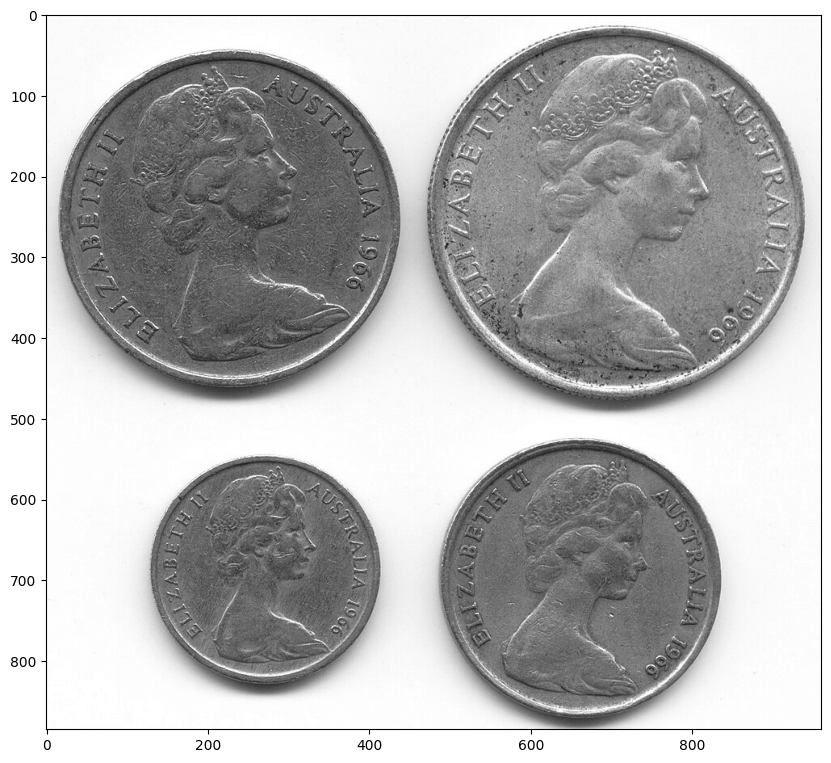

In [19]:
plt.imshow(im_exercise_3_gray, cmap="gray")

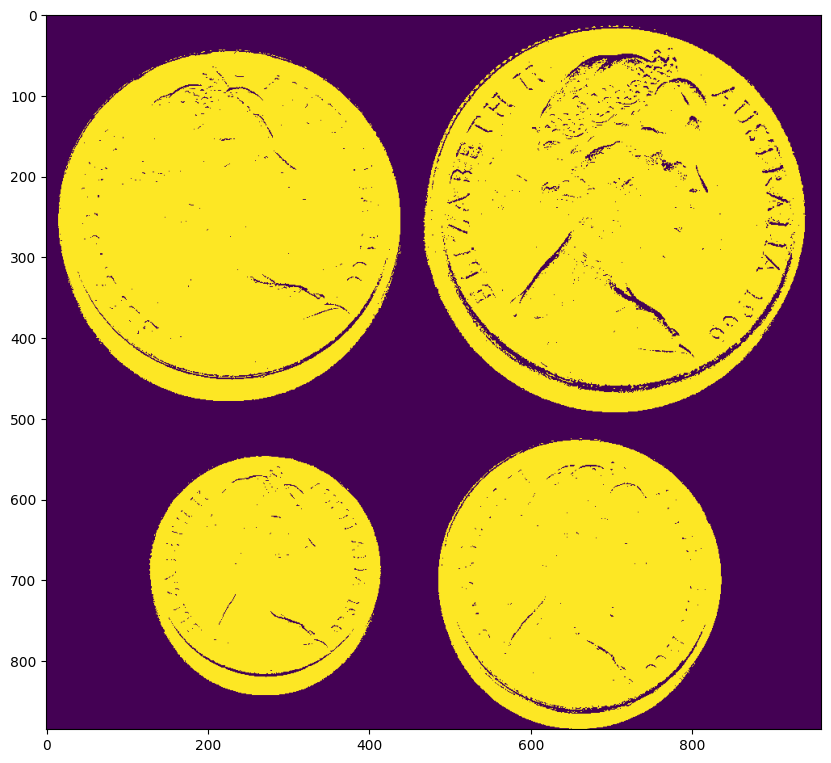

In [20]:
binarized_ext3 = im_exercise_3_gray < 0.75
plt.imshow(binarized_ext3)

In [21]:
labels_ex3 = skimage.measure.label(binarized_ext3)
total_connected_regions_ex3: int = np.unique(labels_ex3).size
print(f'Total connected regions: {total_connected_regions_ex3}')

Total connected regions: 188


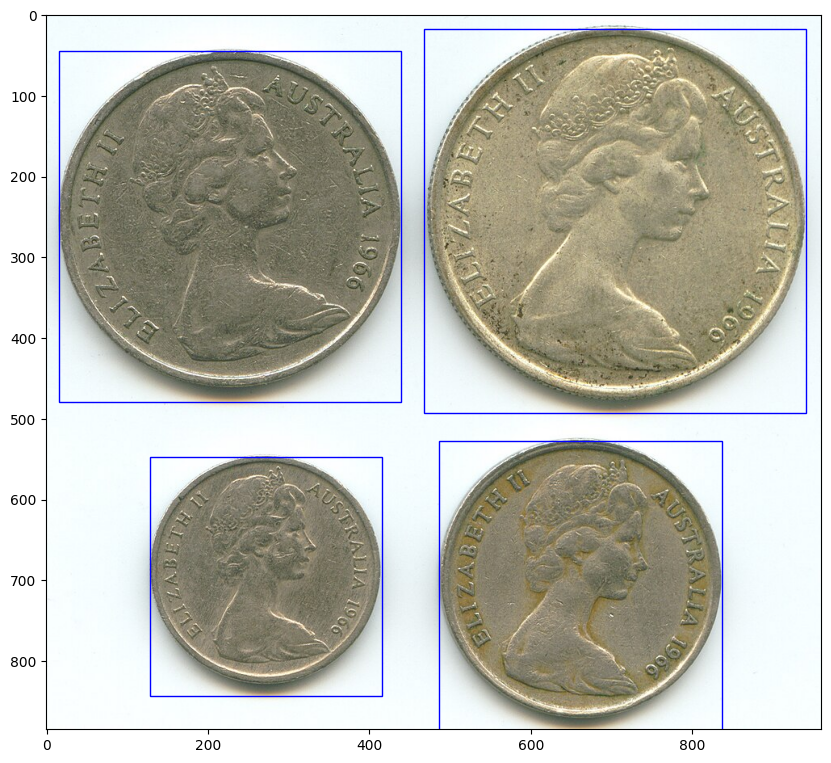

In [22]:
regions_ex3: list = skimage.measure.regionprops(labels_ex3)
sorted_regions_ex3 = sorted(regions_ex3, key= lambda x: x.area)

_, ax_ex3 = plt.subplots()
ax_ex3.imshow(im_exercise_3_orig)
for region in sorted_regions_ex3[-4:]:
    (min_row, min_col, max_row, max_col) = region.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='b', facecolor='none')
    ax_ex3.add_patch(rect)

In [ ]:
target_directory_ext3: pathlib.Path = pathlib.Path.cwd().joinpath('coins_elizabeth')
target_directory_ext3.mkdir(parents=True, exist_ok=True)

for idx, current_region in enumerate(sorted_regions_ex3[-4:]):
    (min_row, min_col, max_row, max_col) = current_region.bbox
    current_coin = im_exercise_3_orig[min_row:max_row, min_col:max_col]
    skimage.io.imsave(fname=target_directory_ext3.joinpath(f'{idx:0>5}.png'), arr=current_coin)

### Exercise 4 (difficult)

Write a function to count the grains of rice in the image found at [this link](https://www.mathworks.com/help/examples/images/win64/NonuniformIlluminationExample_01.png), and return the largest and smallest grain size in pixels.

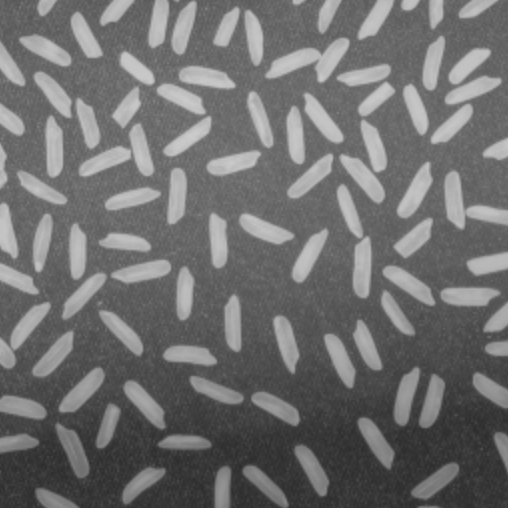

Note that thresholding is difficult due to uneven illumination (the bottom part is darker); try it!  One possible solution is to look for the darkest intensity in each row and subtract that value from all values in that row.  The code below shows an example.

Text(0.5, 1.0, 'Mask with double pieces')

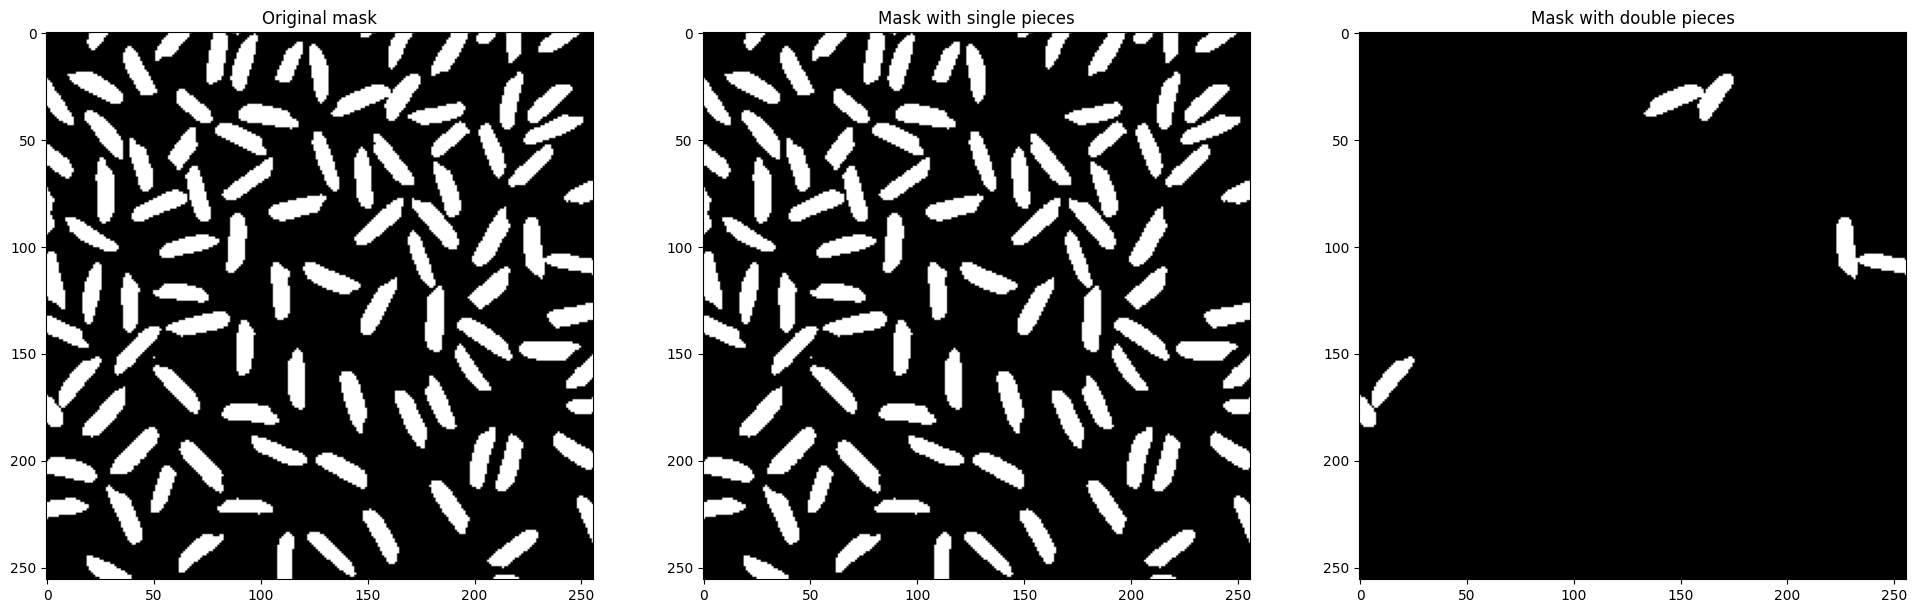

In [236]:
path_rice: pathlib.Path = pathlib.Path.cwd().joinpath('data', 'rice.png')
img_rice = skimage.io.imread(path_rice)
img_rice = skimage.img_as_float(img_rice)
img_height, img_width = img_rice.shape

for i in range(img_height):
    img_rice[i] = img_rice[i] - min(img_rice[i])

mask = img_rice > 0.25
mask_double_rice = skimage.morphology.area_opening(mask, area_threshold=230, connectivity=2)
mask_single_rice = mask & ~mask_double_rice

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(24, 12))
ax0.imshow(mask, cmap="gray")
ax0.set_title("Original mask")
ax1.imshow(mask_single_rice, cmap="gray")
ax1.set_title("Mask with single pieces")
ax2.imshow(mask_double_rice, cmap="gray")
ax2.set_title("Mask with double pieces")

In [237]:
# For mask with double rice
label_double_rice = skimage.measure.label(mask_double_rice)
regions_double_rice: list = skimage.measure.regionprops(label_double_rice)
print(f'Regions with double rice: {len(regions_double_rice)}')

# For mask with single rice
label_single_rice = skimage.measure.label(mask_single_rice)
regions_single_rice: list = skimage.measure.regionprops(label_single_rice)
regions_single_rice_cleaned: list = [region for region in regions_single_rice if region.area > 10]
print(f'Regions with single rice: {len(regions_single_rice)}')


Regions with double rice: 3
Regions with single rice: 96


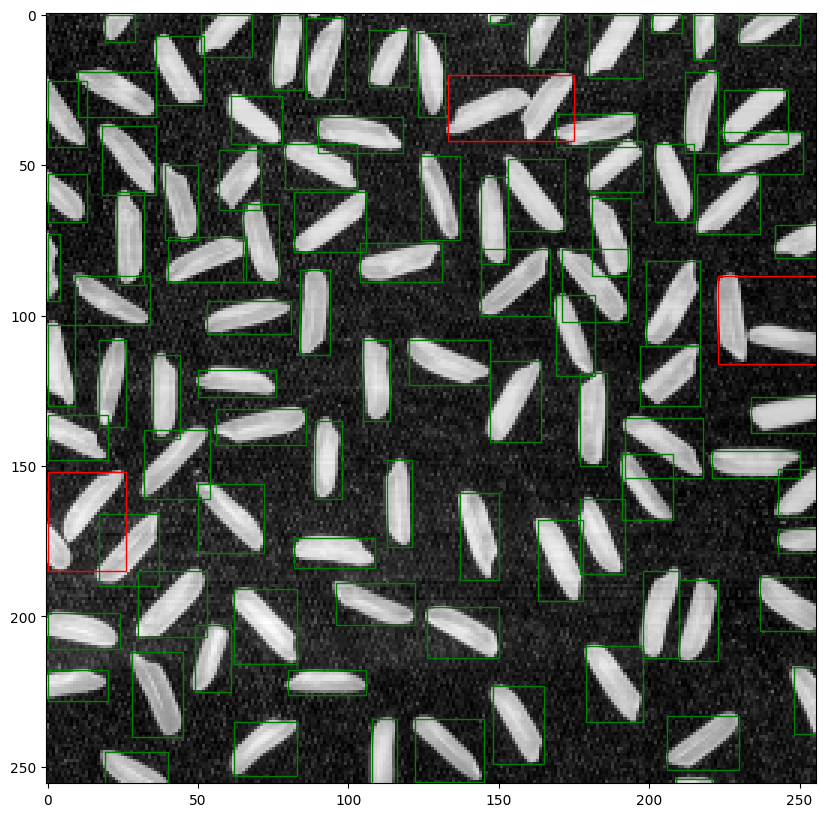

In [240]:
_, ax_ex3 = plt.subplots()
ax_ex3.imshow(img_rice, cmap="gray")

for region in regions_single_rice_cleaned:
    (min_row, min_col, max_row, max_col) = region.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='g', facecolor='none')
    ax_ex3.add_patch(rect)

for region in regions_double_rice:
    (min_row, min_col, max_row, max_col) = region.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax_ex3.add_patch(rect)